In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modularprophet.containers import Model, Sequential, Ensemble
from modularprophet.compositions import Additive, Stationary
from modularprophet.components import Trend, Regressor
from modularprophet.modules.ar_net import LaggedNet
from modularprophet.modules.seasonality import FourierSeasonality
from modularprophet.forecaster import ModularProphet

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/air_passengers.csv")

In [ ]:
m = ModularProphet(
    Sequential(
        Trend(),
        FourierSeasonality("yearly", period=365.25, series_order = 5, growth="linear"),
        #LaggedNet(n_lags=5)
    )
)
m

In [ ]:
m.fit(df, n_forecasts=10, learning_rate=0.1)

In [ ]:
x, y, y_hat, components = m.predict(df[:15])

In [ ]:
pd.DataFrame(y).T.plot()

In [ ]:
pd.DataFrame(y_hat.T).plot()

### Convert Predictions to Readable Format

In [ ]:
def array_to_df(name, array):
    df = pd.DataFrame(array)
    df.columns = [f"{name}_({c + 1})" for c in df.columns]
    return df

def long_to_staircase_df(df):
    n_shifts = ["".join(filter(str.isdigit, c)) for c in list(df.columns)]
    n_shifts = [int(c)-1 if c != "" else 0 for c in n_shifts]
    for i in range(max(n_shifts)):
        df = pd.concat([df, pd.Series(np.nan, dtype=np.float32)], axis=0, ignore_index=True)
    for col, shifts in zip(df.columns, n_shifts):
        df[col] = df[col].shift(shifts)
    df.drop([0], axis=1, inplace=True)
    return df

In [ ]:
prediction_df = {name: array_to_df(name, c) for name, c in components.items()}
prediction_df = pd.concat(prediction_df.values(), axis=1)
staircase_df = long_to_staircase_df(prediction_df)

In [ ]:
y_df = pd.concat([pd.DataFrame(y[:,0], columns=["y"], dtype=np.float32), pd.DataFrame(y[-1][1:], columns=["y"])], axis=0, ignore_index=True)
x_df = pd.concat([pd.DataFrame(x[:,0], columns=["x"], dtype=np.float32), pd.DataFrame(x[-1][1:], columns=["x"])], axis=0, ignore_index=True)

staircase_df = pd.concat([
    staircase_df,
    y_df,
    x_df,
], axis=1)

In [ ]:
staircase_df

In [ ]:
staircase_df.plot(x="x", colormap="viridis_r")

### Evaluate Average Error per Forecast Step

In [ ]:
error_df = staircase_df.copy()
for col in [c for c in error_df.columns if c != "x"]:
    error_df[col] = (error_df[col] - staircase_df["y"])**2
res = error_df.mean()
res[[c for c in error_df.columns if "y_hat" in c]].plot.bar()

### Backtesting with rolling origin and re-fitting

In [3]:
def calculate_metrics(y, y_hat, naive, seasonal_naive):
    mae = 1/len(y) * np.sum(np.abs(y - y_hat))
    rmse = np.sqrt(1/len(y) *np.sum((y - y_hat)**2))
    mase = 1/len(y) * np.sum(np.abs(y - y_hat) / (1/len(y) * np.sum(np.abs(y - naive))))
    smase = 1/len(y) * np.sum(np.abs(y - y_hat) / (1/len(y) * np.sum(np.abs(y - seasonal_naive))))
    mape = 1/len(y) * np.sum(np.abs(y - y_hat) / y)
    return {"MAE": mae, "RMSE": rmse, "MASE": mase, "sMASE": smase, "MAPE": mape}

def naive_forecasts(train_df, seasonal_cycle, n_forecasts):
    # Extract the last value from the training set and repeat it n_forecasts times
    naive = train_df["y"].tail(1).values * np.ones(n_forecasts)
    # Extract the last seasonal_cycle values from the training set and repeat them n_forecasts // seasonal_cycle + 1 times
    seasonal_naive = np.tile(train_df["y"].tail(seasonal_cycle).values, n_forecasts // seasonal_cycle + 1)[:n_forecasts]
    return naive, seasonal_naive

def split_data(df, i, holdout, n_forecasts, n_lags):
    train_df = df[i:-holdout+n_forecasts+i]
    eval_df = df[-holdout+n_forecasts-n_lags+i:].head(n_forecasts + n_lags)
    y = eval_df["y"].values[-n_forecasts:]
    return train_df, eval_df, y

In [4]:
n_forecasts = 10
n_lags = 0
holdout = 44
seasonal_cycle = 12
num_splits = (holdout - 2 * n_forecasts) + 1
metrics = {}
predictions = []

for i in range(0, num_splits):
    train_df, eval_df, y = split_data(df, i, holdout, n_forecasts, n_lags)
    m = ModularProphet(
        Sequential(
            Trend(),
            FourierSeasonality("yearly", period=365.25, series_order = 5, growth="linear"), # growth="linear" #multiply_with="Trend"
            #LaggedNet(n_lags=n_lags)
        )
    )
    m.fit(train_df, n_forecasts=10, learning_rate=0.1) # optimizer="adam",
    # Evaluation
    _, _, y_hat, _ = m.predict(eval_df)
    prediction = y_hat.squeeze(0)
    predictions.append(np.pad(prediction, (i, num_splits-i), mode="constant", constant_values=(np.nan)))
    # Metrics
    naive, seasonal_naive = naive_forecasts(train_df, seasonal_cycle, n_forecasts)
    metrics[i] = calculate_metrics(y, prediction, naive, seasonal_naive)

The model does not contain any components with n_lags attribute.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/karl/git/idic/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type   | Params
---------------------------------
0 | model | Single | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/Users/karl/git/idic/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which

In [5]:
predictions

[array([373.67505, 364.63712, 367.12927, 430.68503, 481.56772, 475.48236,
        410.30463, 350.1978 , 297.9065 , 344.18088,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan],
       dtype=float32),
 array([      nan, 366.1328 , 367.9508 , 429.33255, 478.48172, 472.55603,
        410.24316, 352.6201 , 303.12964, 347.19666, 355.31934,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan],
       dtype=float32),
 array([      nan,       nan, 369.81677, 420.13617, 461.7146 , 460.58188,
        409.

<Axes: >

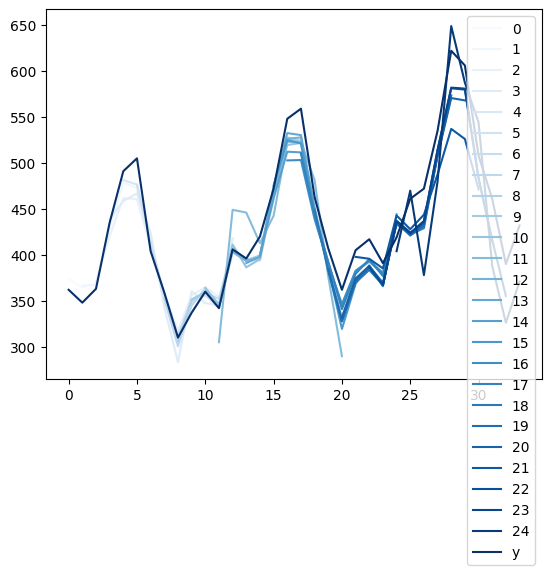

In [6]:
predictions_combined = pd.DataFrame(np.array(predictions)).T[:-1]
predictions_combined["y"] = df[-len(predictions_combined):]["y"].values
predictions_combined.plot(colormap="Blues")

<Axes: >

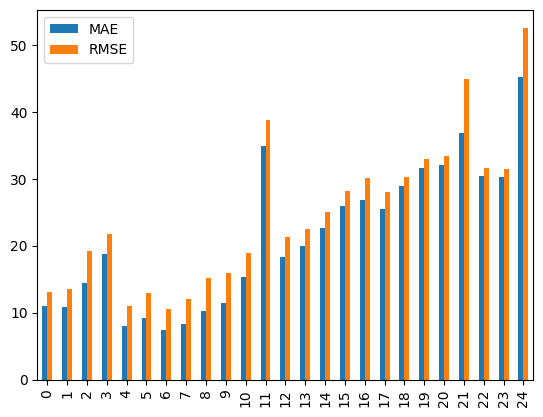

In [7]:
pd.DataFrame(metrics).T[["MAE", "RMSE"]].plot.bar()

<Axes: >

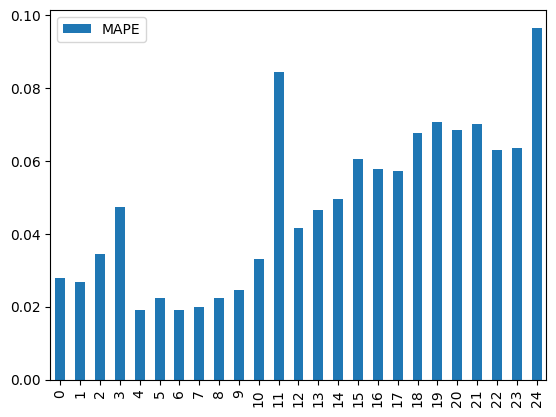

In [8]:
pd.DataFrame(metrics).T[["MAPE"]].plot.bar()

<Axes: >

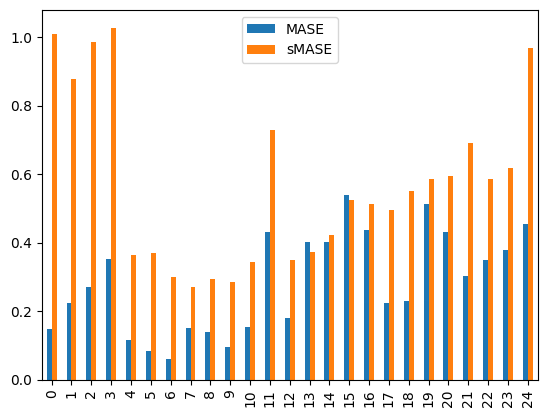

In [9]:
pd.DataFrame(metrics).T[["MASE", "sMASE"]].plot.bar()

### Benchmarking

In [ ]:
import pandas as pd
from utils import store_dataframes
from models import evaluate_modularprophet

In [ ]:
n_forecasts = 10
n_lags = 0

default = {
        "dataset": "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/air_passengers.csv",
        "n_forecasts": n_forecasts, 
        "n_lags": 0,
        "step_size": 1,
        "holdout": 44,
        "seasonal_cycle": 12,
}

configs = {
    "ModularProphet": [{
         "n_lags": 0,
    }],
}

In [ ]:
metrics = pd.DataFrame()
predictions = pd.DataFrame()

for key, value in configs.items():
    if key == "ModularProphet":
        for config in value:
            config.update(default)
            metrics_df, predictions_df = evaluate_modularprophet(**config)
            metrics_df["model"] = "ModularProphet"
            predictions_df.columns = [f"ModularProphet({c})" for c in list(predictions_df.columns)]
            metrics = pd.concat([metrics, metrics_df])
            predictions = pd.concat([predictions, predictions_df], axis=1)
            store_dataframes(metrics, predictions, config["dataset"], "ModularProphet")

In [ ]:
pd.read_csv("air_passengers/ModularProphet_predictions.csv").plot()